In [1]:
from math import exp
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

from nnode1 import nnode1

# Introduction

This notebook will demonstrate how to use the code in the nnode1.py module.

## Define the ODE to solve

In [2]:
# Define the analytical solution.
def yanal(x):
    return 1 + exp(-x**2 / 2)

# Define the original differential equation:
# dy/dx + x*y = x  ->  dy/dx = x*(1 - y) = F(x,y)
def F(x, y):
    return x * (1 - y)

# Define the y-partial derivative of the differential equation.
def dF_dy(x, y):
    return -x

# Define the 2nd y-partial derivative of the differential equation.
def d2F_dy2(x, y):
    return 0

Plot the analytical solution and derivative.

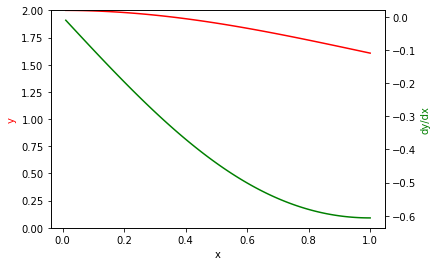

In [3]:
xamin = 0
xamax = 1
nanal = 100
dxa = (xamax - xamin) / nanal
xa = np.arange(xamin, xamax, dxa) + dxa
ya = np.zeros(nanal)
dya_dx = np.zeros(nanal)
for i in range(nanal):
    ya[i] = yanal(xa[i])
    dya_dx[i] = F(xa[i], ya[i])
(fig, ax1) = plt.subplots()
ax1.plot(xa, ya, color = 'r')
ax1.set_xlabel('x')
ax1.set_ylabel('y', color = 'r')
plt.ylim((0, 2))
ax2 = ax1.twinx()
ax2.plot(xa, dya_dx, color = 'g')
ax2.set_ylabel('dy/dx', color = 'g');

## Define the boundary conditions

In [4]:
xmin = 0
xmax = 1
ymin = 2
ymax = None

## Create the training data

In [5]:
ntrain = 10
dx = (xmax - xmin) / ntrain
x = np.arange(xmin, xmax, dx) + dx

## Train the model to solve the ODE

In [6]:
(yt, dyt_dx) = nnode1(x, F, dF_dy, d2F_dy2, xmin, ymin,
                     eta = 0.01, maxepochs = 1000, nhid = 10)

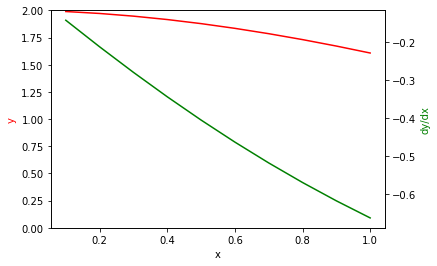

In [7]:
(fig, ax1) = plt.subplots()
ax1.plot(x, yt, color = 'r')
ax1.set_xlabel('x')
ax1.set_ylabel('y', color = 'r')
plt.ylim((0, 2))
ax2 = ax1.twinx()
ax2.plot(x, dyt_dx, color = 'g')
ax2.set_ylabel('dy/dx', color = 'g');

Plot the error in the estimated solution and derivative.

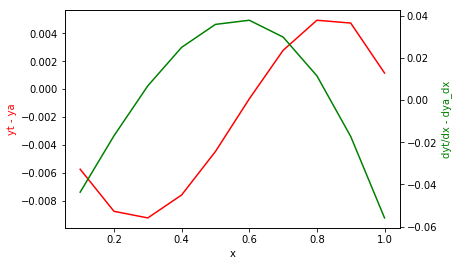

In [8]:
xamin = 0
xamax = 1
nanal = 10
dxa = (xamax - xamin) / nanal
xa = np.arange(xamin, xamax, dxa) + dxa
ya = np.zeros(nanal)
dya_dx = np.zeros(nanal)
for i in range(nanal):
    ya[i] = yanal(xa[i])
    dya_dx[i] = F(xa[i], ya[i])

(fig, ax1) = plt.subplots()
ax1.plot(x, yt - ya, color = 'r')
ax1.set_xlabel('x')
ax1.set_ylabel('yt - ya', color = 'r')
#plt.ylim((0, 2))
ax2 = ax1.twinx()
ax2.plot(x, dyt_dx - dya_dx, color = 'g')
ax2.set_ylabel('dyt/dx - dya_dx', color = 'g');